In [107]:
import pandas as pd
import numpy as np
import os
import re
from matplotlib import pyplot as plt

## Load and concat data to one frame

In [96]:
df = pd.DataFrame()


for file_name in sorted(list(os.listdir('dotacie_pre'))):
    if not re.match('dotacie_ours_20[01][0-9]_NA.csv', file_name):
        continue
    year = int(file_name.replace('dotacie_ours_', '')[:4])
    if year in [2010, 2011, 2012]:
        delim, dec, th  = ',', '.', ' '
        temp = pd.read_csv(f'dotacie_pre/{file_name}', delimiter=delim, decimal=dec, thousands=th)
    else:
        delim, dec, th = ';', ',', ''
        temp = pd.read_csv(f'dotacie_pre/{file_name}', delimiter=delim, decimal=dec)

    temp['rok'] = year
    df = pd.concat([df, temp], axis = 0)

for col in df.columns:
    if col == 'univerzita':
        continue
    df[col] = pd.to_numeric(df[col])

display(df['univerzita'].value_counts())
display(df['rok'].value_counts())


UK       11
UPJŠ     11
KU       11
AU       11
VŠVU     11
VŠMU     11
TUZVO    11
SPU      11
EU       11
TUAD     11
ŽU       11
TUKE     11
STU      11
TVU      11
UMB      11
UKF      11
UVL      11
UCM      11
PU       11
UJS      11
Name: univerzita, dtype: int64

2009    20
2010    20
2011    20
2012    20
2013    20
2014    20
2015    20
2016    20
2017    20
2018    20
2019    20
Name: rok, dtype: int64

In [97]:
df = df[['rok', 'univerzita', 'dotacie', 'mzdy', 'dotacie-stud', 'studenti', 'studenti-denni',
       'ubyt-kap-sd', 'ubyt-studenti-sd', 'prispevok-sd', 'pub-podiel-07711', 'pub-podiel-07712']].copy()
df.sample(3)


,rok,univerzita,dotacie,mzdy,dotacie-stud,studenti,studenti-denni,ubyt-kap-sd,ubyt-studenti-sd,prispevok-sd,pub-podiel-07711,pub-podiel-07712
15,2018,VŠMU,8204570.0,3326020,185839,1030.0,885.0,0.0,0.0,0.0,0.275206,0.073496
4,2010,UVL,8791849.0,3995447,604476,1626.0,1464.0,899.0,775.0,41744.0,NaN,NaN
13,2016,SPU,22448022.0,7583985,2501905,8704.0,6468.0,2736.0,2608.0,195488.0,4.271514,4.050937


In [98]:
facts = list(df.columns)
facts.remove('univerzita')
facts.remove('rok')
totals = (
    pd.concat(
        [df
        .groupby('rok')
        ['univerzita'].nunique()
        .to_frame(name = 'univerzity')]
        + [df
        .groupby('rok')
        [col].sum()
        .to_frame(name = col) for col in facts],
        axis = 1)
        .reset_index()
        )

totals

,rok,univerzity,dotacie,mzdy,dotacie-stud,studenti,studenti-denni,ubyt-kap-sd,ubyt-studenti-sd,prispevok-sd,pub-podiel-07711,pub-podiel-07712
0,2009,20,3.829316e+08,172547633,50274862,194554.0,137739.0,46320.0,43901.0,3352848.0,0.0,0.0
1,2010,20,3.941945e+08,177193101,45552844,187120.0,138507.0,48175.0,44747.0,3326000.0,0.0,0.0
2,2011,20,3.925506e+08,122195435,47744810,178779.0,134334.0,46140.0,42896.0,3288800.0,0.0,0.0
3,2012,20,3.091253e+08,126633305,52043774,178779.0,128222.0,46140.0,44401.0,3288800.0,0.0,0.0
4,2013,20,4.103603e+08,126633305,53252028,172823.0,133175.0,45910.0,44094.0,3425888.0,100.0,100.0
5,2014,20,4.135335e+08,133523287,49175301,165905.0,131347.0,45961.0,43335.0,3358752.0,100.0,100.0
6,2015,20,4.215895e+08,135020294,50776959,158110.5,117520.5,45856.0,42390.0,3292528.0,100.0,100.0
7,2016,20,4.433257e+08,143400897,48926749,148673.0,111161.0,44939.0,40879.0,3132560.0,100.0,100.0
8,2017,20,4.468004e+08,146893641,46983871,140015.0,103981.0,45077.0,39554.0,3024512.0,100.0,100.0
9,2018,20,4.661215e+08,160104584,45924046,130857.5,98115.5,44757.0,39824.0,2970880.0,100.0,100.0


## Inflacia stonks

In [89]:
def inflation_data(file_name = '../data/cpi_slovakia_20230102.csv', since = 2009, ref_month = 1):
    cpi_df = pd.read_csv('../data/cpi_slovakia_20230102.csv')[['Rok', 'Mesiac', 'Úhrn']]
    cpi_df.columns = ['rok', 'mesiac', 'cpi']
    cpi_df = cpi_df.query('mesiac == @ref_month and rok >= @since')
    ref_value = list(cpi_df.query('rok == @since')['cpi'])[0]
    cpi_df['inflation_rate'] = cpi_df['cpi'] / ref_value
    return cpi_df[['rok', 'inflation_rate']]

# inflation_data()

In [108]:
df_copy = df.merge(inflation_data(), on = 'rok', how = 'left')
df_copy['dotacie_ia'] = pd.to_numeric(df_copy['dotacie'] / df_copy['inflation_rate'], downcast='float')
df_copy.to_csv('dotacie_ours_final.csv', index = False)

In [103]:
facts = list(df_copy.columns)
facts.remove('univerzita')
facts.remove('rok')
facts.remove('inflation_rate')
totals = (
    pd.concat(
        [df_copy
        .groupby('rok')
        ['univerzita'].nunique()
        .to_frame(name = 'univerzity')]
        + [df_copy
        .groupby('rok')
        [col].sum()
        .to_frame(name = col) for col in facts],
        axis = 1)
        .reset_index()
        )

totals

,rok,univerzity,dotacie,mzdy,dotacie-stud,studenti,studenti-denni,ubyt-kap-sd,ubyt-studenti-sd,prispevok-sd,pub-podiel-07711,pub-podiel-07712,dotacie_ia
0,2009,20,3.829316e+08,172547633,50274862,194554.0,137739.0,46320.0,43901.0,3352848.0,0.0,0.0,382931616.0
1,2010,20,3.941945e+08,177193101,45552844,187120.0,138507.0,48175.0,44747.0,3326000.0,0.0,0.0,392613536.0
2,2011,20,3.925506e+08,122195435,47744810,178779.0,134334.0,46140.0,42896.0,3288800.0,0.0,0.0,379559040.0
3,2012,20,3.091253e+08,126633305,52043774,178779.0,128222.0,46140.0,44401.0,3288800.0,0.0,0.0,287693152.0
4,2013,20,4.103603e+08,126633305,53252028,172823.0,133175.0,45910.0,44094.0,3425888.0,100.0,100.0,372827360.0
5,2014,20,4.135335e+08,133523287,49175301,165905.0,131347.0,45961.0,43335.0,3358752.0,100.0,100.0,375710336.0
6,2015,20,4.215895e+08,135020294,50776959,158110.5,117520.5,45856.0,42390.0,3292528.0,100.0,100.0,384671392.0
7,2016,20,4.433257e+08,143400897,48926749,148673.0,111161.0,44939.0,40879.0,3132560.0,100.0,100.0,406996448.0
8,2017,20,4.468004e+08,146893641,46983871,140015.0,103981.0,45077.0,39554.0,3024512.0,100.0,100.0,407425056.0
9,2018,20,4.661215e+08,160104584,45924046,130857.5,98115.5,44757.0,39824.0,2970880.0,100.0,100.0,414887168.0


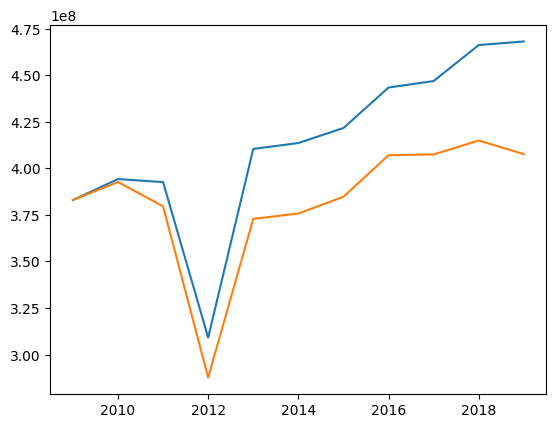

In [106]:
plt.plot(totals['rok'], totals['dotacie'])
plt.plot(totals['rok'], totals['dotacie_ia'])